In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import NNSingleFeatureModel, tims_mse_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
from time import time
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

In [2]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')

def load_data(raw, dataset='', validation=False):
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/{key}.pkl')
    return raw[key]

In [3]:
def load_sub_model_with_config(train_config, model_configs, sub_model_key, X_count=0, force_recreate=False):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    model_config = model_configs[sub_model_key]
    f = f"{path}/{prefix}{sub_model_key}.pth"
    if os.path.exists(f) and not force_recreate:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        next_epoch = checkpoint['next_epoch']
    else:
        raise Exception('Model does not exist')
    return net, loss_func, optimizer, mean_losses, next_epoch

In [4]:
# # incase i need to save the current model in memory
# def save_model_with_config(train_config, sub_model_key, **kwargs):
#     path = train_config['model_path']
#     prefix = train_config['model_prefix']
#     f = f"{path}/{prefix}{sub_model_key}.pth"
#     torch.save(kwargs, f)

In [5]:
def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    model.eval()
    X_tensor = torch.from_numpy(X.to_numpy()).float()
    nn_results = model(X_tensor).detach().numpy()
    return nn_results

In [6]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [7]:
train_config = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_prefix' : "TRY_2_", 
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t5_models",
    'device' : 'cpu',
}

In [8]:
%%time
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=train_config['dataset'],validation=True)).dropna()
ref_test, X_test, y_test = get_ref_X_y(test_df)
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG', 'y_BSTAR']
y_test = y_test[y_cols]

Loading data to cache for: sample_test
CPU times: user 388 ms, sys: 564 ms, total: 952 ms
Wall time: 3.45 s


In [9]:
model_configs = {
    'y_INCLINATION': { 'feature_index': X_test.columns.get_loc('X_INCLINATION_1') },
    'y_ECCENTRICITY': { 'feature_index': X_test.columns.get_loc('X_ECCENTRICITY_1') },
    'y_MEAN_MOTION': { 'feature_index': X_test.columns.get_loc('X_MEAN_MOTION_1') },
    'y_RA_OF_ASC_NODE_REG': { 'feature_index': X_test.columns.get_loc('X_RA_OF_ASC_NODE_1') },
    'y_ARG_OF_PERICENTER_REG': { 'feature_index': X_test.columns.get_loc('X_ARG_OF_PERICENTER_1') },
    'y_REV_MA_REG': { 'feature_index': X_test.columns.get_loc('X_MEAN_ANOMALY_1') },
    'y_BSTAR': { 'feature_index': X_test.columns.get_loc('X_BSTAR_1') },
}

Loading existing model
y_ARG_OF_PERICENTER_REG
MSELoss()


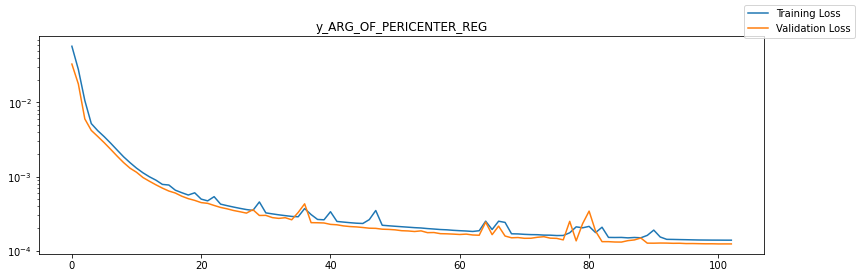

Epoch 103
    Test set MAE (L1) loss: 0.005542648095226548
    Test set MSE (L2) loss: 0.00017489809859241845


,train loss,validation loss
98,0.000139776633,0.000124411475
99,0.000139497822,0.000124471751
100,0.000139412604,0.000123934880
101,0.000139215676,0.000123981103
102,0.000139161887,0.000123939358


0.100     0.244210119629
0.200     0.490771533203
0.300     0.747100020753
0.400     1.021371499024
0.500     1.326642785644
0.600     1.682959664306
0.700     2.124352520751
0.800     2.747879289550
0.900     3.887192598572
0.950     5.293368837891
0.975     7.081412987671
0.990    11.265250634278
0.999    40.961855280705
Name: error, dtype: float64

,y_ARG_OF_PERICENTER_REG,y_ARG_OF_PERICENTER_REG_pred,X_ARG_OF_PERICENTER_1,error,epoch_diff
0,-0.000193333333,0.088952995837,0.003265833333,32.092678918457,0.062329100000
1,0.987631111111,0.973203182220,0.999806666667,5.194050585937,0.228539867143
2,0.980530833333,1.002207636833,0.987631111111,7.803638769531,0.135046149998
3,0.976759166667,1.059797644615,0.980530833333,29.893860644531,0.062328921429
4,0.972732777778,1.031238794327,0.976759166667,21.062171679687,0.083105090000
...,...,...,...,...,...
335637,0.292393888889,0.285179316998,0.350423333333,2.597249218750,1.605606008571
335638,0.282199444444,0.275305390358,0.340186666667,2.481860424805,1.605595280000
335639,0.282199444444,0.273157119751,0.350423333333,3.255236889649,1.887101960000
335640,0.037817777778,0.029709354043,0.079460277778,2.919032186890,1.136312644286


count    335642.000000000000
mean          1.983247174480
std           3.790070588573
min           0.000002050781
25%           0.617729031373
50%           1.326642785644
75%           2.402526333618
max         179.998662014771
Name: error, dtype: float64

In [118]:
# Create or load all new sub models here if needed.
# sample_idx = random.sample(list(X_test.index), 10000)
sample_idx = X_test.index
all_models = {}
display_data = []
# for sub_key in y_cols:
for sub_key in ['y_ARG_OF_PERICENTER_REG']:
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key)
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)
    try:
        tl, vl = zip(*mean_losses)
        print(f'{sub_key}')
    except:
        print(f"No data for {sub_key}")
        continue

    fig,ax = plt.subplots(figsize=(13,4))
    print(loss_func)
    ax.plot(tl, label="Training Loss")
    ax.plot(vl, label="Validation Loss")
    ax.set_title(sub_key)
    ax.set_yscale('log')
    ax.set_ylim((ax.get_ylim()[0], min(1,ax.get_ylim()[1])))
    fig.legend()
    plt.show()
    
    trained_model = model
    X_sample = X_test.loc[sample_idx]
    y_sample = y_test.loc[sample_idx][[sub_key]]
    y_sample_pred = predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
    y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe
    print(f'Epoch {next_epoch}')
    print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
    print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')
    display_data.append(y_sample)
    display_data.append(y_sample_pred_df.add_suffix('_pred'))
    display_data.append(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1].values - y_sample_pred_df.values)
    display(pd.DataFrame(mean_losses, columns=['train loss','validation loss']).tail())
    print('==============================')
df = pd.concat(display_data, axis=1)
df['error'] = (np.abs(df.iloc[:,0]*360 - df.iloc[:,1]*360))%360
df['error'] = np.minimum(360-df.error,df.error)
display(df.error.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999]))
df['epoch_diff'] = X_sample.X_delta_EPOCH
display(df)
display(df.error.describe())

In [121]:
df = df.sort_values('error', ascending=False)
df = df.merge(ref_test, left_index=True, right_index=True)

In [125]:
esdf = df.copy()

In [133]:
ed = esdf.groupby(by='__GP_ID_1')['error'].describe()

In [149]:
ed.sort_values('mean', ascending=False).head(30).merge(ref_test[['__GP_ID_1','__NORAD_CAT_ID_1']].drop_duplicates(subset=['__GP_ID_1']), left_index=True, right_on='__GP_ID_1').head(30)

,count,mean,std,min,25%,50%,75%,max,__GP_ID_1,__NORAD_CAT_ID_1
247166,10.0,177.201206261215,2.113770598682,173.309896176147,176.613866179466,177.595284430695,177.947544136047,179.998662014771,58067405,28974
250913,4.0,171.127577612305,1.105476884254,169.500992724610,170.903712249756,171.570424719238,171.794290081787,171.868468286133,82574413,28974
250912,4.0,166.673833258057,7.927395333470,160.975106225587,162.042260644532,163.712432336426,168.344004949952,178.295362133789,82562836,28974
247167,9.0,159.887218503528,2.128436984175,157.198279614258,158.476120492554,159.701166947937,160.776543278122,163.364966650772,58075674,28974
251163,5.0,156.911647041016,2.574036003601,153.498302294922,155.959679199219,156.632572656250,157.992383203125,160.475297851563,87696669,28974
317835,5.0,153.484470986328,14.496084649854,145.449008105469,146.059934033203,147.766757666016,148.843201904297,179.303453222656,79453647,36024
247165,11.0,135.740778808143,5.435114452351,120.299821134567,135.317218354034,136.984638711548,138.588652737427,140.060248394775,58048829,28974
250977,1.0,134.547512858581,NaN,134.547512858581,134.547512858581,134.547512858581,134.547512858581,134.547512858581,83491720,28974
317453,7.0,127.060257910156,44.830815562241,62.351196264648,90.008926696777,150.834311767578,161.764351562500,172.689740820313,73740967,36024
317806,4.0,122.965625122070,72.963010800379,15.783208447266,107.367571215820,152.737316845703,168.335370751953,170.604658349609,79393916,36024


In [ ]:
# another model overview
# Load all new sub models here if needed.
all_models = {}
for sub_key in model_configs.keys():
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key, len(X_test.columns), force_recreate=False)
    try:
        tl, vl = zip(*mean_losses)
    except:
        print(f"No data for {sub_key}")
        continue
    print(f'{sub_key}\nEpoch:      {next_epoch}\nLast TLoss: {tl[-1]}\nLast VLoss: {vl[-1]}')
    print(f'Loss func:  {loss_func}\nOptimizer:  {optimizer}')
    print('---------')
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)

In [93]:
# nums = ((90 * 360 * np.abs((df.y_REV_MA_REG - df.y_REV_MA_REG_pred)))%360)
# nums = np.minimum(nums, np.abs(360-nums))
# nums.name = "MEAN_ANOMALY_ERROR"
# nums.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999])

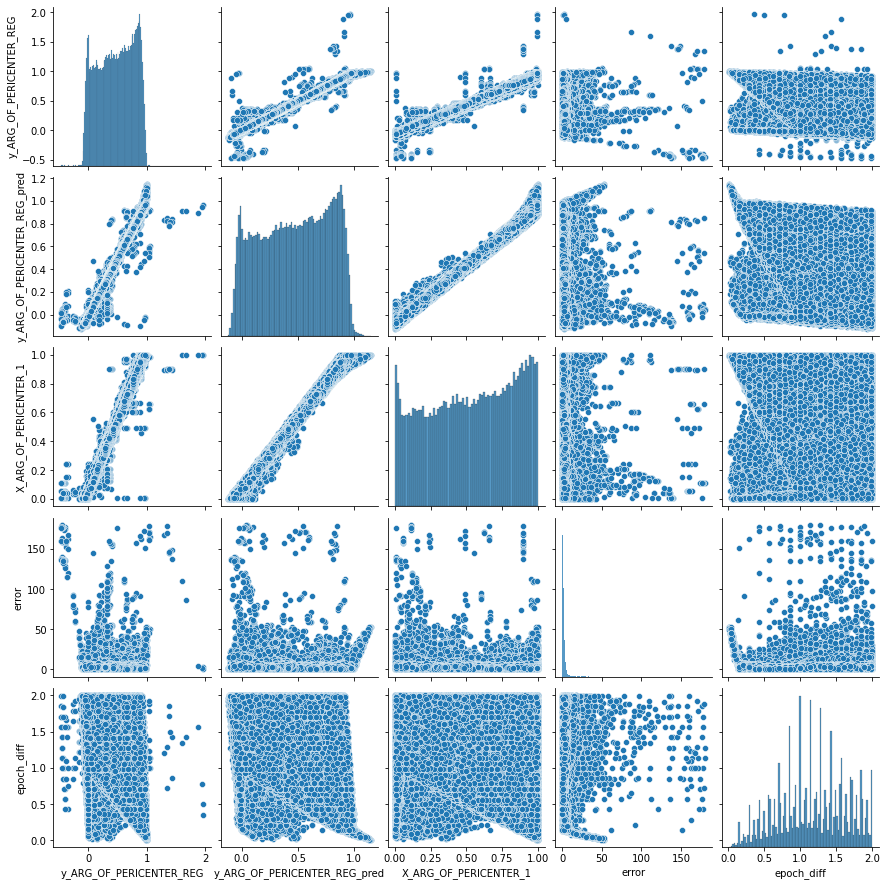

In [119]:
import seaborn

seaborn.pairplot(df)

AdamW optimizer
Decrease learning rate slowly over time
Decrease weight decay if both training and validation are decreasing similarly